<a href="https://colab.research.google.com/github/eoinleen/Biophysics-general/blob/main/dianthus_spectral_shift_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dianthus Binding Assay Analysis v11.0 MERGED


Saving 20260114-fitting-Dianthus.xlsx to 20260114-fitting-Dianthus (2).xlsx

Analyzing 9 datasets...

COMPREHENSIVE BINDING ANALYSIS — ALL MODELS WITH AIC SELECTION


/tmp/ipython-input-70299899.py:137: RuntimeWarning: invalid value encountered in power
  return bottom + (top - bottom) / (1 + (kd / x) ** hill)
/tmp/ipython-input-70299899.py:274: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(
/tmp/ipython-input-70299899.py:137: RuntimeWarning: overflow encountered in power
  return bottom + (top - bottom) / (1 + (kd / x) ** hill)


Protein    Model                      ★  Kd(nM)    R²     AIC      90% CI             95% CI             CV%    Sat%   Class      CI_flag      Notes
----------------------------------------------------------------------------------------------------------------------------------------------------
110287     One site (decrease)        ★  677.58    0.995  -219.0   [616.7–750.0]      [607.5–759.4]      6.0%   98.5   Apparent   OK             (still rising) (max≈67.0×Kd)
110287     One site (increase)           677.58    0.995  -219.0   [608.7–751.2]      [593.0–767.3]      6.6%   98.5   Apparent   OK             (still rising) (max≈67.0×Kd)
110287     Spectral shift (basic)        647.74    0.995  -218.8   [584.5–716.6]      [570.1–733.5]      6.6%   98.6   Apparent   OK            spectral-model (still rising) (max≈70.1×Kd)
110287     Hill equation                 687.03    0.995  -217.2   [608.7–780.9]      [590.6–801.5]      7.6%   98.4   Apparent   OK           n=0.98  (still rising) 

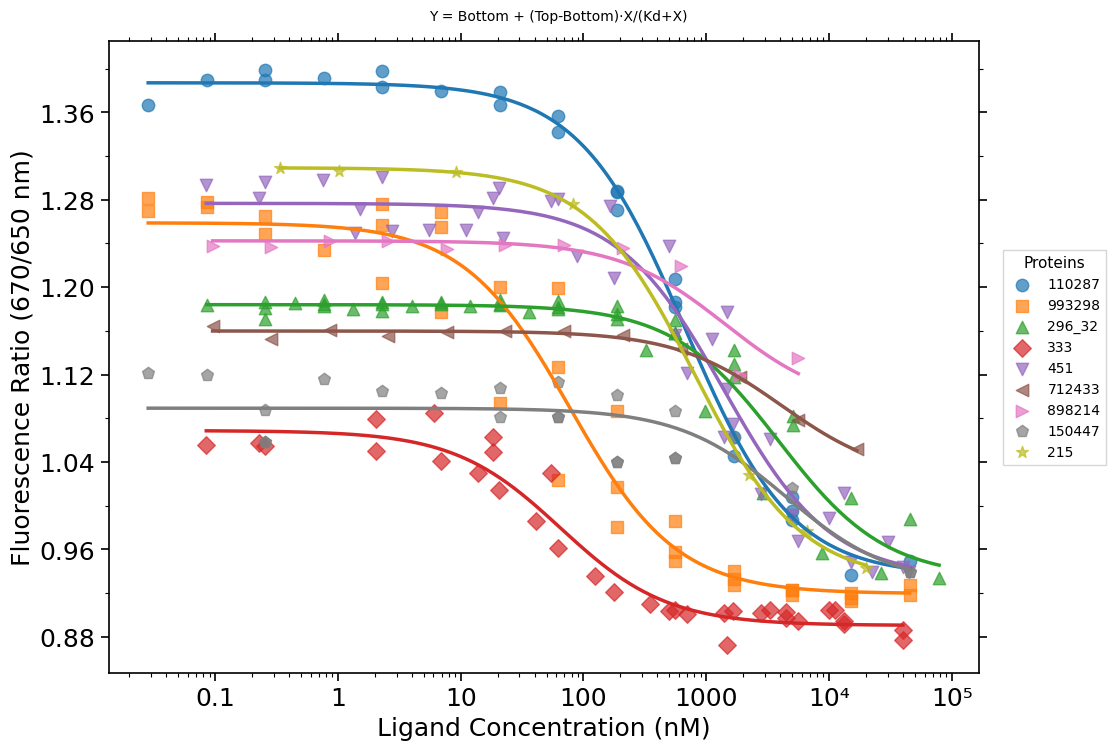

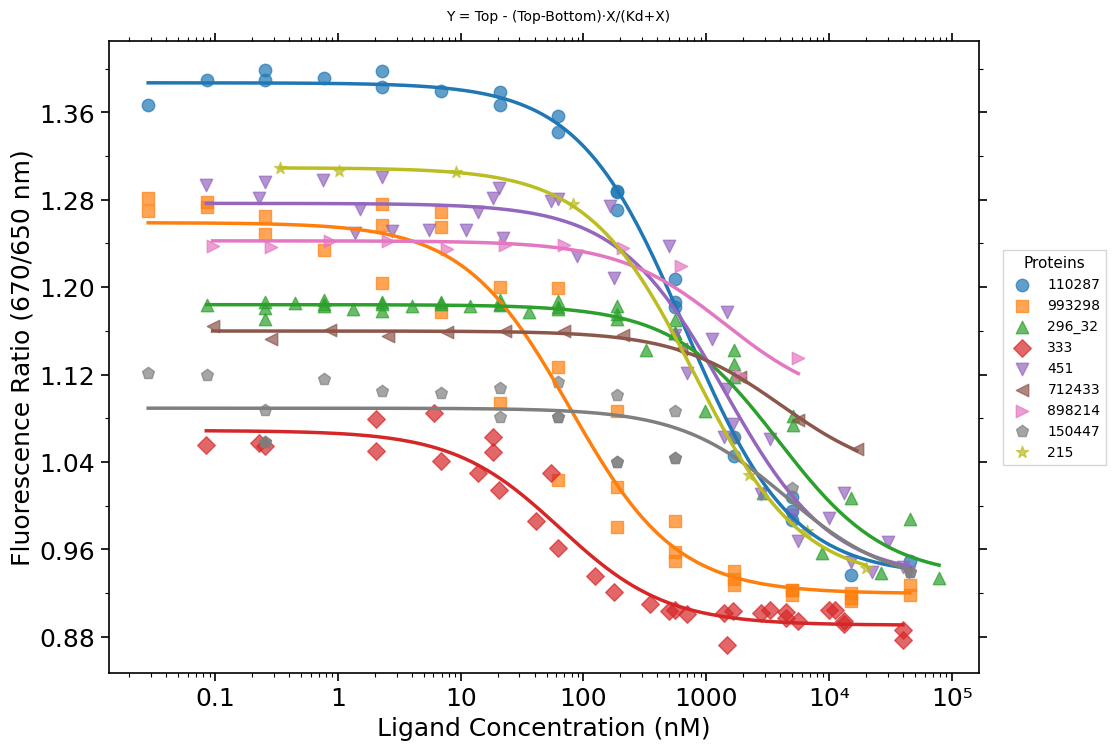

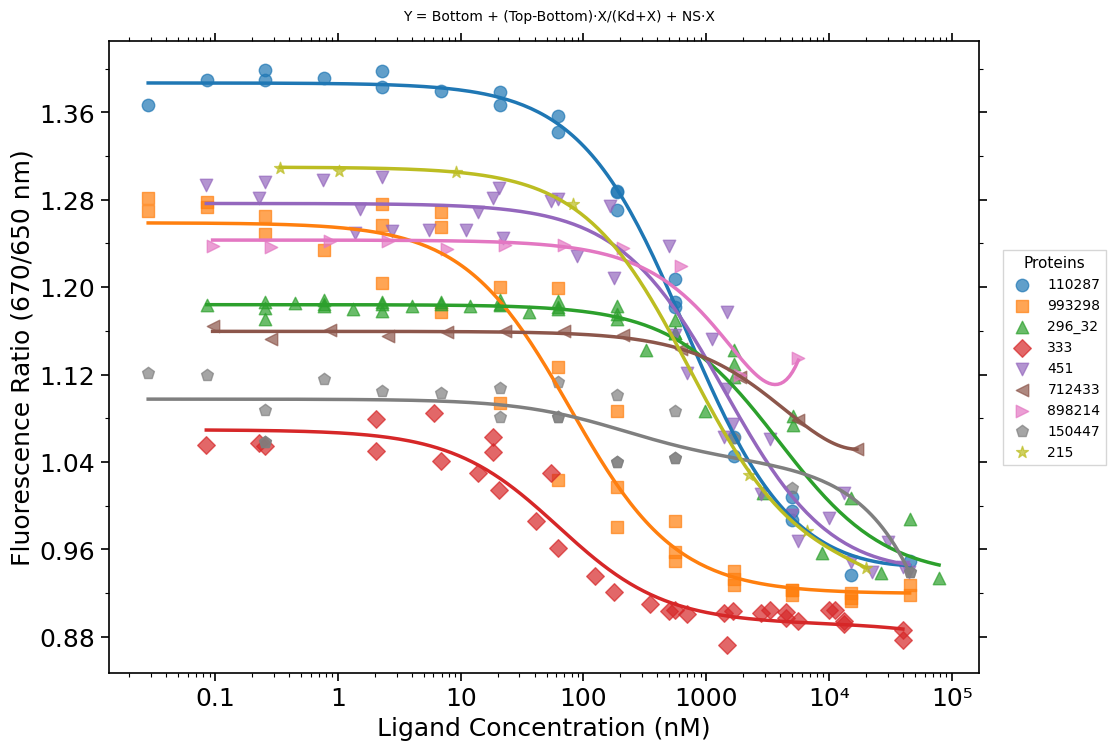

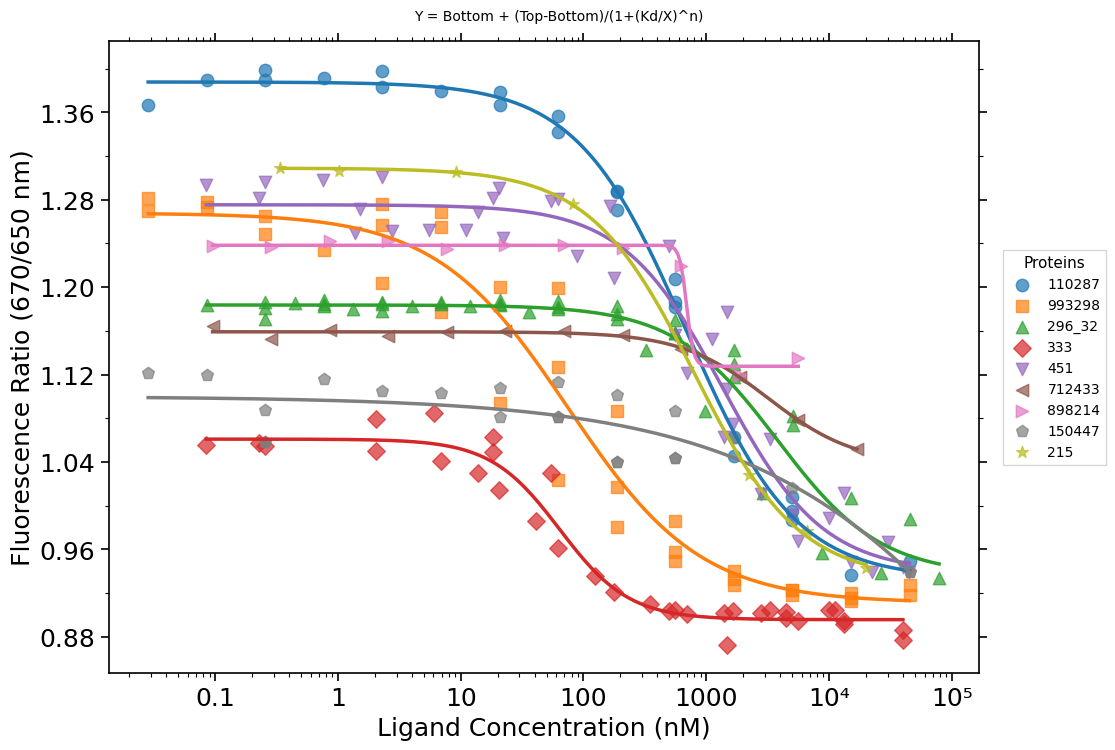

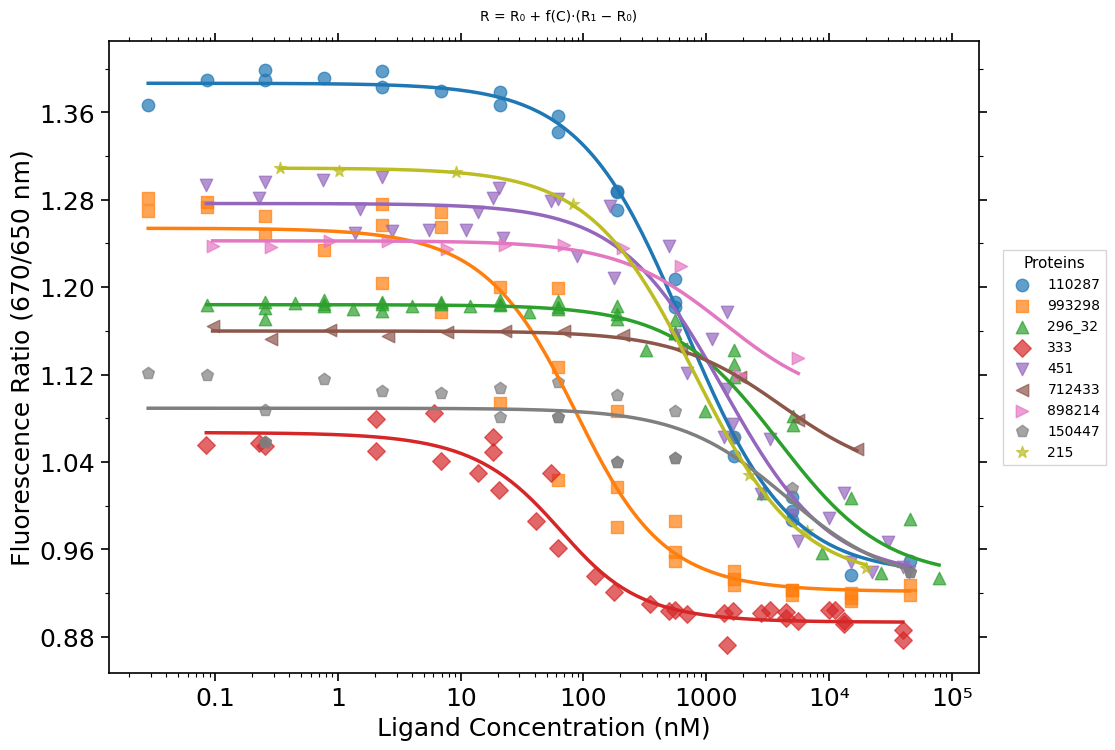


Exporting plots to binding_model_plots...
✓ Plots exported and zipped: binding_model_plots.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


DRAFT: MATERIALS AND METHODS (DATA ANALYSIS)

DATA PROCESSING AND MODELING:
Binding affinity (Kd) was determined by analyzing the change in fluorescence
ratios as a function of ligand concentration. Data analysis was performed
using a custom Python-based analysis suite (v11.0) utilizing the SciPy
optimization library.

1. MODEL SELECTION & EQUATION(S)
The experimental data were fit to the One site (increase), One site (decrease), One site + non-specific, Hill equation and Spectral shift (basic) models.
The following equations were utilized:
  - One site (increase): Y = Bottom + (Top-Bottom)·X/(Kd+X)
  - One site (decrease): Y = Top - (Top-Bottom)·X/(Kd+X)
  - One site + non-specific: Y = Bottom + (Top-Bottom)·X/(Kd+X) + NS·X
  - Hill equation: Y = Bottom + (Top-Bottom)/(1+(Kd/X)^n)
  - Spectral shift (basic): R = R₀ + f(C)·(R₁ − R₀)


2. COMPUTATIONAL FITTING PROCEDURE
Non-linear least squares regression was performed using the 'curve_fit'
algorithm from the SciPy 'optimize' module (v

In [3]:
"""
Dianthus Binding Assay Analysis Script v11.0 MERGED
====================================================
Publication-grade binding analysis combining comprehensive reporting with robust statistics.

NEW IN v11 MERGED
-----------------
- AIC-based model selection (ChatGPT)
- Slope-aware saturation classification (ChatGPT)
- Residual-based bootstrap confidence intervals (ChatGPT)
- Physical sanity checks on Kd (ChatGPT)
- Automatic per-model plot export with ZIP archive (ChatGPT)
- Comprehensive statistics table (Original)
- Dynamic "Materials and Methods" generator (Original)
- Publication-quality overlay plots by model (Original)
- Full styling customization (Original)
"""

# ============================================================================
# USER OPTIONS & REPORTING CONFIGURATION
# ============================================================================

TARGET_PROTEIN_CONCENTRATION_NM = 50.0
TARGET_PROTEIN_CONCENTRATION_M = TARGET_PROTEIN_CONCENTRATION_NM * 1e-9

# REPORT SELECTION: Comment out (#) models NOT used in your final paper
MODELS_TO_REPORT = [
    "One site (increase)",
    "One site (decrease)",
    "One site + non-specific",
    "Hill equation",
    "Spectral shift (basic)",
]

EXCEL_HAS_HEADER = True
PLOT_ALL_DATA_ON_SINGLE_GRAPH = True

# Export settings
EXPORT_PLOTS = True
PLOT_EXPORT_DIR = "binding_model_plots"

# ============================================================================
# STYLE OPTIONS
# ============================================================================

PLOT_STYLE = {
    "font_family": "DejaVu Sans",
    "line_width": 2.5,
    "marker_size": 80,
    "background": "none",
    "grid": False,
    "tick_direction": "out",
    "tick_length_major": 6,
    "tick_length_minor": 3,
}

FONT_SIZES = {
    "title_size": 0,
    "axis_label_size": 18,
    "tick_label_size": 18,
    "annotation_size": 10,
    "legend_size": 10,
}

COLOR_SCHEMES = {
    "presentation": {
        "colors": ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                   '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'],
        "markers": ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    }
}

ACTIVE_COLOR_SCHEME = "presentation"

def apply_plot_style():
    import matplotlib.pyplot as plt
    plt.rcParams.update({
        "font.family": PLOT_STYLE["font_family"],
        "font.size": FONT_SIZES["tick_label_size"],
        "axes.labelsize": FONT_SIZES["axis_label_size"],
        "xtick.labelsize": FONT_SIZES["tick_label_size"],
        "ytick.labelsize": FONT_SIZES["tick_label_size"],
        "legend.fontsize": FONT_SIZES["legend_size"],
        "axes.linewidth": 1.2,
        "axes.grid": PLOT_STYLE["grid"],
        "figure.facecolor": PLOT_STYLE["background"],
        "axes.facecolor": PLOT_STYLE["background"],
    })

apply_plot_style()

# ============================================================================
# IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import traceback
import sys
import os
import shutil

try:
    from google.colab import files
    from IPython.display import display
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# ============================================================================
# COLOR MANAGEMENT
# ============================================================================

def get_pair_style(pair_idx):
    scheme = COLOR_SCHEMES[ACTIVE_COLOR_SCHEME]
    return (
        scheme["colors"][pair_idx % len(scheme["colors"])],
        scheme["markers"][pair_idx % len(scheme["markers"])]
    )

# ============================================================================
# MODELS
# ============================================================================

def one_site_binding_increase(x, bottom, top, kd):
    return bottom + (top - bottom) * x / (kd + x)

def one_site_binding_decrease(x, top, bottom, kd):
    return top - (top - bottom) * x / (kd + x)

def one_site_binding_ns(x, bottom, top, kd, ns):
    return bottom + (top - bottom) * x / (kd + x) + ns * x

def hill_equation_bidirectional(x, bottom, top, kd, hill):
    return bottom + (top - bottom) / (1 + (kd / x) ** hill)

def fraction_bound_spectral_shift(c_ligand, kd, c_target):
    term = c_ligand + c_target + kd
    sqrt_term = np.sqrt(np.maximum(term**2 - 4*c_ligand*c_target, 0))
    return np.clip((term - sqrt_term) / (2*c_target), 0, 1)

def spectral_shift_basic(x, r_unbound, r_bound, kd):
    f = fraction_bound_spectral_shift(x, kd, TARGET_PROTEIN_CONCENTRATION_M)
    return r_unbound + f * (r_bound - r_unbound)

def get_equation_string(name):
    return {
        'One site (increase)': 'Y = Bottom + (Top-Bottom)·X/(Kd+X)',
        'One site (decrease)': 'Y = Top - (Top-Bottom)·X/(Kd+X)',
        'One site + non-specific': 'Y = Bottom + (Top-Bottom)·X/(Kd+X) + NS·X',
        'Hill equation': 'Y = Bottom + (Top-Bottom)/(1+(Kd/X)^n)',
        'Spectral shift (basic)': 'R = R₀ + f(C)·(R₁ − R₀)'
    }.get(name, '')

# ============================================================================
# STATISTICS UTILITIES (ChatGPT improvements)
# ============================================================================

def aic(n, rss, k):
    """Akaike Information Criterion - lower is better"""
    return n * np.log(rss/n) + 2 * k if rss > 0 else np.inf

def local_slope_near_max(model, max_conc):
    """Calculate local slope near maximum concentration to detect non-saturation"""
    func = model["function"]
    params = model["params"]
    x1 = max_conc * 0.8
    x2 = max_conc
    y1 = func(x1, *params)
    y2 = func(x2, *params)
    return abs((y2 - y1) / (x2 - x1))

def assess_saturation(model, max_conc):
    """
    Model-aware saturation assessment with slope detection.
    Returns percent, qualitative class, and diagnostics.
    """
    name = model["name"]
    params = model["params"]
    kd = params[model["kd_index"]]

    # Default outputs
    percent = np.nan
    diagnostic = ""
    extra = ""

    # ---- Model-specific fractional saturation ----
    if name == "Hill equation":
        bottom, top, kd, n = params
        frac = 1 / (1 + (kd / max_conc) ** n)
        percent = 100 * frac
        extra = f"n={n:.2f}"

        # Hill coefficient sanity check
        if n > 4:
            extra += " [HIGH_n!]"
        elif n < 0.5:
            extra += " [LOW_n!]"

    elif name in ["One site (increase)", "One site (decrease)", "One site + non-specific"]:
        frac = max_conc / (kd + max_conc)
        percent = 100 * frac

    elif name == "Spectral shift (basic)":
        frac = fraction_bound_spectral_shift(
            max_conc, kd, TARGET_PROTEIN_CONCENTRATION_M
        )
        percent = 100 * frac
        diagnostic = "spectral-model"

    else:
        percent = np.nan

    # ---- Fold-over-Kd diagnostic ----
    fold = max_conc / kd if kd > 0 else np.nan

    # ---- Classification ----
    if percent >= 90 and fold >= 10:
        sat_class = "Excellent"
    elif percent >= 75 and fold >= 5:
        sat_class = "Good"
    elif percent >= 60 and fold >= 3:
        sat_class = "Moderate"
    elif percent >= 40:
        sat_class = "Poor"
    else:
        sat_class = "Very Poor"

    # ---- Slope-based adjustment (ChatGPT improvement) ----
    try:
        slope = local_slope_near_max(model, max_conc)
        dyn = abs(params[1] - params[0]) if len(params) >= 2 else 1
        slope_norm = slope / dyn
        if slope_norm > 0.02:  # Still rising significantly
            sat_class = "Apparent"
            diagnostic += " (still rising)"
    except:
        pass

    diagnostic += f" (max≈{fold:.1f}×Kd)"

    return {
        "percent": percent,
        "class": sat_class,
        "diagnostic": diagnostic,
        "extra": extra
    }

def bootstrap_kd_ci(model, conc, ratios, n_boot=300):
    """
    Residual-based bootstrap for Kd confidence intervals (ChatGPT improvement).
    More robust than data resampling for heteroscedastic data.
    Returns dict with 90%, 95%, CV, and effective sample size.
    """
    func = model["function"]
    params0 = model["params"]
    kd_idx = model["kd_index"]

    try:
        fitted = func(conc, *params0)
        residuals = ratios - fitted
    except:
        return None

    kd_vals = []

    for _ in range(n_boot):
        # Resample residuals and add to fitted values
        resampled = np.random.choice(residuals, len(residuals), replace=True)
        synthetic = fitted + resampled
        try:
            popt, _ = curve_fit(
                func,
                conc,
                synthetic,
                p0=params0,
                maxfev=3000
            )
            kd_vals.append(popt[kd_idx] * 1e9)
        except:
            pass

    # Require reasonable convergence
    if len(kd_vals) < 0.4 * n_boot:
        return None

    kd_vals = np.asarray(kd_vals)

    return {
        "90": np.percentile(kd_vals, [5, 95]),
        "95": np.percentile(kd_vals, [2.5, 97.5]),
        "cv": 100 * np.std(kd_vals) / np.mean(kd_vals),
        "n_eff": len(kd_vals)
    }

# ============================================================================
# REPORT GENERATORS (Original)
# ============================================================================

def generate_dynamic_methods(selected_models, protein_conc_nm):
    """
    Generates a publication-ready Materials and Methods section
    dynamically based on the user's selected models.
    """
    if not selected_models:
        return "No models selected for reporting."

    count = len(selected_models)
    is_plural = count > 1
    model_list_str = ", ".join(selected_models[:-1]) + (f" and {selected_models[-1]}" if is_plural else selected_models[0])

    equation_details = ""
    for m in selected_models:
        equation_details += f"  - {m}: {get_equation_string(m)}\n"

    methods_text = f"""
{"="*80}
DRAFT: MATERIALS AND METHODS (DATA ANALYSIS)
{"="*80}

DATA PROCESSING AND MODELING:
Binding affinity (Kd) was determined by analyzing the change in fluorescence
ratios as a function of ligand concentration. Data analysis was performed
using a custom Python-based analysis suite (v11.0) utilizing the SciPy
optimization library.

1. MODEL SELECTION & EQUATION(S)
The experimental data {"were" if is_plural else "was"} fit to the {model_list_str} {"models" if is_plural else "model"}.
The following {"equations were" if is_plural else "equation was"} utilized:
{equation_details}

2. COMPUTATIONAL FITTING PROCEDURE
Non-linear least squares regression was performed using the 'curve_fit'
algorithm from the SciPy 'optimize' module (v1.11+). The algorithm utilized
the Trust Region Reflective (TRF) method with a maximum of 5,000 iterations.
Initial parameter guesses were programmatically generated based on the median
concentration and signal range of the raw data to ensure global convergence.

Model selection was performed using the Akaike Information Criterion (AIC),
which balances goodness of fit with model complexity. The model with the
lowest AIC value was identified as the preferred model for each dataset.
Physical sanity checks were applied to reject fits with Kd values outside
reasonable bounds (0 < Kd < 100× maximum concentration).

3. KD DETERMINATION & CONFIDENCE INTERVALS
Kd was derived as a fitted parameter representing the dissociation constant.
For the Spectral Shift model, the script accounts for the depletion of
free ligand by incorporating the fixed target protein concentration
([{protein_conc_nm} nM]) into a quadratic binding equation.

Statistical uncertainty for the Kd values was estimated using a residual-based
bootstrap analysis (n=300). Residuals from the best-fit model were resampled
with replacement and added to the fitted curve to generate synthetic datasets.
Each synthetic dataset was re-fit to the chosen model(s), and the 95%
confidence intervals (CIs) were defined by the 2.5th and 97.5th percentiles
of the resulting Kd distribution. This approach is more robust to
heteroscedastic data than traditional data-point resampling.

4. GOODNESS OF FIT AND QUALITY CONTROL
The coefficient of determination (R²) was calculated as:
    R² = 1 - (SS_res / SS_tot)
where SS_res is the sum of squares of residuals and SS_tot is the total
sum of squares. Fits were categorized by saturation percentage; results where
the maximum ligand concentration failed to reach 3× the calculated Kd, or
where theoretical saturation was below 60%, were flagged as "Extrapolated"
to denote reduced numerical confidence.

Additionally, a slope-based analysis was performed near the maximum
concentration to detect non-saturating conditions. Datasets showing normalized
slopes >2% were flagged as "Apparent" saturation, indicating the binding
curve was still rising appreciably at the highest tested concentration.

{"="*80}
"""
    print(methods_text)

# ============================================================================
# FITTING ENGINE (ChatGPT improvements + Original)
# ============================================================================

def analyze_binding_data(conc_m, ratios):
    """Fit all models and return comprehensive results with AIC-based selection"""
    models = []

    conc = np.asarray(conc_m)
    ratios = np.asarray(ratios)
    mask = (conc > 0) & np.isfinite(conc) & np.isfinite(ratios)
    conc, ratios = conc[mask], ratios[mask]

    if len(conc) < 4:
        return None

    bottom, top = np.min(ratios), np.max(ratios)
    kd_guess = np.median(conc)

    def try_fit(name, func, p0, bounds, kd_index):
        try:
            popt, pcov = curve_fit(func, conc, ratios, p0=p0, bounds=bounds, maxfev=5000)

            # Physical sanity check on Kd (ChatGPT improvement)
            kd_val = popt[kd_index]
            if kd_val <= 0 or kd_val > conc.max() * 100:
                raise ValueError("Unphysical Kd")

            fitted = func(conc, *popt)
            ss_res = np.sum((ratios - fitted)**2)
            ss_tot = np.sum((ratios - np.mean(ratios))**2)
            r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

            # Calculate AIC (ChatGPT improvement)
            aic_val = aic(len(conc), ss_res, len(popt))

            models.append({
                "name": name,
                "function": func,
                "params": popt,
                "kd_index": kd_index,
                "r2": r2,
                "aic": aic_val,
                "equation": get_equation_string(name)
            })
        except Exception:
            pass

    try_fit("One site (increase)", one_site_binding_increase,
            [bottom, top, kd_guess], ([0,0,1e-12],[np.inf]*3), 2)

    try_fit("One site (decrease)", one_site_binding_decrease,
            [top, bottom, kd_guess], ([0,0,1e-12],[np.inf]*3), 2)

    try_fit("One site + non-specific", one_site_binding_ns,
            [bottom, top, kd_guess, 0], ([0,0,1e-12,-np.inf],[np.inf]*4), 2)

    try_fit("Hill equation", hill_equation_bidirectional,
            [bottom, top, kd_guess, 1], ([0,0,1e-12,0.1],[np.inf]*4), 2)

    try_fit("Spectral shift (basic)", spectral_shift_basic,
            [ratios[0], ratios[-1], kd_guess], ([0,0,1e-12],[np.inf]*3), 2)

    if not models:
        return None

    # Best model by AIC (ChatGPT improvement)
    best = min(models, key=lambda m: m["aic"])

    x_smooth = np.logspace(np.log10(conc.min()), np.log10(conc.max()), 200)
    y_smooth = best["function"](x_smooth, *best["params"])

    return {
        "original_conc": conc,
        "original_ratios": ratios,
        "smooth_conc": x_smooth,
        "smooth_ratios": y_smooth,
        "parameters": best["params"],
        "kd_index": best["kd_index"],
        "method": best["name"],
        "equation": best["equation"],
        "all_models": models,
        "best_model": best  # Explicitly mark the AIC-selected best model
    }

# ============================================================================
# PLOTTING (Original with enhancements)
# ============================================================================

def plot_overlays_by_model(all_data, fit_results, protein_names=None):
    """Create publication-quality overlay plots grouped by model type"""
    print("\nOVERLAY PLOTS BY MODEL TYPE")

    from matplotlib.ticker import FuncFormatter, MultipleLocator, MaxNLocator

    def smart_log_formatter(x, pos):
        if x <= 0:
            return ""

        if x < 10000:
            if x >= 1:
                return f"{x:.0f}"
            else:
                return f"{x:.1f}"

        exponent = int(np.log10(x))
        mantissa = x / (10 ** exponent)

        superscripts = str.maketrans("0123456789-", "⁰¹²³⁴⁵⁶⁷⁸⁹⁻")

        if abs(mantissa - 1.0) < 1e-6:
            return f"10{str(exponent).translate(superscripts)}"
        else:
            return f"{mantissa:.0f}×10{str(exponent).translate(superscripts)}"

    grouped = {}
    for pair_idx, result in fit_results.items():
        for model in result["all_models"]:
            grouped.setdefault(model["name"], []).append((pair_idx, model))

    for model_name, entries in grouped.items():
        fig, ax = plt.subplots(figsize=(12, 8))

        for pair_idx, model in entries:
            color, marker = get_pair_style(pair_idx)
            data = all_data[pair_idx]

            conc_nm = data["conc"] * 1e9

            if protein_names and pair_idx < len(protein_names):
                label = protein_names[pair_idx]
            else:
                label = f"Sample {pair_idx + 1}"

            ax.scatter(conc_nm, data["ratios"], s=PLOT_STYLE["marker_size"],
                      color=color, alpha=0.7, marker=marker, label=label)

            xs = np.logspace(np.log10(data["conc"].min()),
                             np.log10(data["conc"].max()), 200)
            ys = model["function"](xs, *model["params"])
            ax.plot(xs*1e9, ys, color=color, linewidth=PLOT_STYLE["line_width"])

        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(FuncFormatter(smart_log_formatter))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=8))
        ax.yaxis.set_minor_locator(MaxNLocator(nbins=16))

        ax.tick_params(axis='both', which='major',
                      length=PLOT_STYLE["tick_length_major"],
                      width=1.2, direction=PLOT_STYLE["tick_direction"])
        ax.tick_params(axis='both', which='minor',
                      length=PLOT_STYLE["tick_length_minor"],
                      width=0.8, direction=PLOT_STYLE["tick_direction"])
        ax.tick_params(top=True, right=True, which='both')

        ax.set_xlabel("Ligand Concentration (nM)",
                     fontsize=FONT_SIZES["axis_label_size"])
        ax.set_ylabel("Fluorescence Ratio (670/650 nm)",
                     fontsize=FONT_SIZES["axis_label_size"])

        equation_text = get_equation_string(model_name)
        if FONT_SIZES["title_size"] > 0:
            fig.suptitle(f"{model_name}", fontsize=FONT_SIZES["title_size"], y=0.98)
        fig.text(0.5, 0.94, equation_text,
                ha='center', va='top', fontsize=FONT_SIZES["annotation_size"],
                transform=fig.transFigure)

        ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                 frameon=True, fancybox=False, shadow=False,
                 fontsize=FONT_SIZES["legend_size"],
                 title="Proteins", title_fontsize=FONT_SIZES["legend_size"]+1)

        plt.subplots_adjust(top=0.90, right=0.85)
        plt.show()

# ============================================================================
# STATISTICS TABLE (Original with AIC column added)
# ============================================================================

def print_statistics_table(fit_results, protein_names):
    """Print comprehensive statistics table with AIC-based model selection"""
    print("\n" + "=" * 210)
    print("COMPREHENSIVE BINDING ANALYSIS — ALL MODELS WITH AIC SELECTION")
    print("=" * 210)

    rows = []

    for pair_idx, result in fit_results.items():
        protein = (
            protein_names[pair_idx]
            if protein_names and pair_idx < len(protein_names)
            else f"Sample {pair_idx+1}"
        )

        conc = result["original_conc"]
        ratios = result["original_ratios"]
        max_conc = np.max(conc)

        # Identify the AIC-selected best model
        best_model_name = result["best_model"]["name"]

        for model in result["all_models"]:
            name = model["name"]
            r2 = model["r2"]
            aic_val = model["aic"]
            params = model["params"]

            kd = params[model["kd_index"]]
            kd_nm = kd * 1e9

            # Mark if this is the AIC-selected best model
            is_best = (name == best_model_name)

            # ---- Saturation assessment ----
            sat = assess_saturation(model, max_conc)

            # ---- CI logic with flags ----
            ci_90 = ci_95 = cv = "—"
            ci_flag = "OK"

            fold = max_conc / kd if kd > 0 else np.nan

            if sat["percent"] < 60:
                ci_flag = "LOW_SAT"
            elif r2 < 0.95:
                ci_flag = "POOR_FIT"
            elif fold < 3:
                ci_flag = "EXTRAPOLATED"
            else:
                ci = bootstrap_kd_ci(model, conc, ratios)
                if ci is None:
                    ci_flag = "BOOT_FAIL"
                else:
                    ci_90 = f"[{ci['90'][0]:.1f}–{ci['90'][1]:.1f}]"
                    ci_95 = f"[{ci['95'][0]:.1f}–{ci['95'][1]:.1f}]"
                    cv = f"{ci['cv']:.1f}%"

            rows.append({
                "protein": protein,
                "model": name,
                "kd": kd_nm,
                "r2": r2,
                "aic": aic_val,
                "sat": sat["percent"],
                "class": sat["class"],
                "ci_90": ci_90,
                "ci_95": ci_95,
                "cv": cv,
                "ci_flag": ci_flag,
                "extra": sat["extra"],
                "diag": sat["diagnostic"],
                "is_best": is_best
            })

    # Sort by protein then AIC (best models first within each protein)
    rows.sort(key=lambda r: (r["protein"], r["aic"]))

    header = (
         f"{'Protein':<10} {'Model':<26} {'★':<2} {'Kd(nM)':<9} "
         f"{'R²':<6} {'AIC':<8} "
         f"{'90% CI':<18} {'95% CI':<18} {'CV%':<6} "
         f"{'Sat%':<6} {'Class':<10} {'CI_flag':<12} {'Notes'}"
    )
    print(header)
    print("-" * len(header))

    last = None
    for r in rows:
        if last and r["protein"] != last:
            print("-" * len(header))

        best_marker = "★" if r["is_best"] else ""

        print(
            f"{r['protein']:<10} "
            f"{r['model']:<26} "
            f"{best_marker:<2} "
            f"{r['kd']:<9.2f} "
            f"{r['r2']:<6.3f} "
            f"{r['aic']:<8.1f} "
            f"{r['ci_90']:<18} "
            f"{r['ci_95']:<18} "
            f"{r['cv']:<6} "
            f"{r['sat']:<6.1f} "
            f"{r['class']:<10} "
            f"{r['ci_flag']:<12} "
            f"{r['extra']} {r['diag']}"
        )
        last = r["protein"]

    print("=" * len(header))

    # ---- Legend ----
    print("\nLEGEND:")
    print("  ★            AIC-selected best model")
    print("  CI FLAGS:")
    print("    OK           CI reliable")
    print("    LOW_SAT      <60% saturation — Kd poorly constrained")
    print("    POOR_FIT     R² < 0.95")
    print("    EXTRAPOLATED Max conc < 3×Kd")
    print("    BOOT_FAIL    Bootstrap unstable / non-convergent")
    print("\n  SATURATION CLASSES:")
    print("    Excellent    ≥90% saturation, max conc ≥10×Kd")
    print("    Good         ≥75% saturation, max conc ≥5×Kd")
    print("    Moderate     ≥60% saturation, max conc ≥3×Kd")
    print("    Poor         ≥40% saturation")
    print("    Apparent     Curve still rising at max concentration")

# ============================================================================
# PLOT EXPORT (ChatGPT improvement)
# ============================================================================

def export_model_plots(all_data, fit_results, protein_names):
    """Export individual plots organized by model type into folders, create ZIP"""
    print(f"\nExporting plots to {PLOT_EXPORT_DIR}...")

    os.makedirs(PLOT_EXPORT_DIR, exist_ok=True)

    grouped = {}
    for i, res in fit_results.items():
        for m in res["all_models"]:
            grouped.setdefault(m["name"], []).append((i, m))

    for model_name, entries in grouped.items():
        safe = model_name.replace(" ", "_").replace("(", "").replace(")", "")
        model_dir = os.path.join(PLOT_EXPORT_DIR, safe)
        os.makedirs(model_dir, exist_ok=True)

        for idx, model in entries:
            fig, ax = plt.subplots(figsize=(9, 6))
            data = all_data[idx]
            conc_nm = data["conc"] * 1e9

            # All black, same marker (circles), dashed lines
            ax.scatter(conc_nm, data["ratios"], s=60, color='black',
                      alpha=0.7, marker='o')

            xs = np.logspace(np.log10(data["conc"].min()),
                           np.log10(data["conc"].max()), 200)
            ys = model["function"](xs, *model["params"])
            ax.plot(xs * 1e9, ys, color='black', linewidth=2.5, linestyle='--')

            ax.set_xscale("log")
            ax.set_xlabel("Ligand Concentration (nM)")
            ax.set_ylabel("Fluorescence Ratio")

            title = protein_names[idx] if protein_names else f"Sample {idx+1}"

            # Get Kd and calculate CI
            kd_nm = model["params"][model["kd_index"]] * 1e9
            r2 = model["r2"]

            # Format Kd based on R² and CI availability
            if r2 < 0.9:
                kd_str = f"Kd ~ {kd_nm:.1f} nM"
            else:
                # Try to get 95% CI
                conc = data["conc"]
                ratios = data["ratios"]
                ci = bootstrap_kd_ci(model, conc, ratios)

                if ci is not None:
                    ci_95 = ci["95"]
                    kd_str = f"Kd = {kd_nm:.1f} ± {(ci_95[1] - ci_95[0])/2:.1f} nM"
                else:
                    kd_str = f"Kd = {kd_nm:.1f} nM"

            # Title with smaller font (10pt instead of default)
            ax.set_title(f"{title} — {model_name}\n"
                        f"R² = {r2:.3f}, {kd_str}",
                        fontsize=10)

            fname = f"{title.replace(' ', '_')}_{safe}.png"
            plt.tight_layout()
            plt.savefig(os.path.join(model_dir, fname), dpi=300,
                       bbox_inches='tight', facecolor='white')
            plt.close(fig)

    # Create ZIP archive
    zip_path = f"{PLOT_EXPORT_DIR}.zip"
    shutil.make_archive(PLOT_EXPORT_DIR, 'zip', PLOT_EXPORT_DIR)
    print(f"✓ Plots exported and zipped: {zip_path}")

    # Offer download in Colab
    if IN_COLAB:
        files.download(zip_path)

# ============================================================================
# FILE ANALYSIS
# ============================================================================

def analyze_uploaded_file_multi(filename):
    """Main analysis pipeline"""
    df_header = pd.read_excel(filename, header=None, nrows=2)

    protein_names = []
    for i in range(0, df_header.shape[1], 2):
        name = df_header.iloc[0, i]
        if pd.notna(name):
            name_str = str(name).strip('"').strip("'")
            protein_names.append(name_str)
        else:
            if i+1 < df_header.shape[1]:
                name = df_header.iloc[0, i+1]
                if pd.notna(name):
                    name_str = str(name).strip('"').strip("'")
                    protein_names.append(name_str)

    df_data = pd.read_excel(filename, header=1)
    n_pairs = df_data.shape[1] // 2

    all_data, fit_results = {}, {}

    print(f"\nAnalyzing {n_pairs} datasets...")
    for i in range(n_pairs):
        conc_nm = df_data.iloc[:, 2*i].dropna().values
        ratios = df_data.iloc[:, 2*i+1].dropna().values
        n = min(len(conc_nm), len(ratios))

        conc_m = conc_nm[:n] * 1e-9
        ratios = ratios[:n]

        all_data[i] = {"conc": conc_m, "ratios": ratios}

        res = analyze_binding_data(conc_m, ratios)
        if res:
            fit_results[i] = res

    # Generate outputs
    print_statistics_table(fit_results, protein_names)

    if PLOT_ALL_DATA_ON_SINGLE_GRAPH:
        plot_overlays_by_model(all_data, fit_results, protein_names)

    if EXPORT_PLOTS:
        export_model_plots(all_data, fit_results, protein_names)

    # Generate Materials & Methods
    generate_dynamic_methods(MODELS_TO_REPORT, TARGET_PROTEIN_CONCENTRATION_NM)

# ============================================================================
# MAIN
# ============================================================================

if __name__ == "__main__":
    if IN_COLAB:
        print("=" * 80)
        print("Dianthus Binding Assay Analysis v11.0 MERGED")
        print("=" * 80)
        uploaded = files.upload()
        if uploaded:
            filename = list(uploaded.keys())[0]
            analyze_uploaded_file_multi(filename)
    else:
        print("Running outside Colab. Please provide filename as command line argument.")
        if len(sys.argv) > 1:
            analyze_uploaded_file_multi(sys.argv[1])